In [1]:
!which pip3

/home/mgross/anaconda3/envs/contrast-net/bin/pip3


In [2]:
! nvidia-smi

Thu Jan 29 04:42:29 2026       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                Off | 00000000:17:00.0 Off |                  Off |
| 33%   29C    P8              23W / 260W |   2118MiB / 49152MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import IPython
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import pytorch_lightning
from monai.visualize import img2tensorboard
import torch
import time
import sklearn

from torch.utils.data import DataLoader

import monai
from monai.transforms import \
    Compose, LoadImaged, AddChanneld, Orientationd, \
    NormalizeIntensityd, ScaleIntensityRangePercentilesd, \
    SpatialPadd, Spacingd, Resized, \
    RandCropByPosNegLabeld, ToTensord,  \
    DataStatsd, AsDiscrete, KeepLargestConnectedComponent, RandFlipd
#LoadNiftid


from monai.data import list_data_collate
from monai.networks.layers import Norm

# from monai.metrics import compute_meandice
from monai.transforms import KeepLargestConnectedComponent

from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm





monai.config.print_config()

MONAI version: 0.7.0
Numpy version: 1.20.3
Pytorch version: 1.8.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: bfa054b9c3064628a21f4c35bbe3132964e91f43

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.3.1
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.2
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
print('CUDA available: ', torch.cuda.is_available())

n_gpus = torch.cuda.device_count()
for i in range(n_gpus):
    print('GPU %d: %s' % (i, torch.cuda.get_device_name(i)))


CUDA available:  True
GPU 0: Quadro RTX 8000


## Load the Data

In [5]:
INPUT_PATH = '../ContrastNets.xlsx'
df = pd.read_excel(INPUT_PATH, index_col=False)

In [6]:
df_train, df_val, df_test = \
              np.split(df.sample(frac=1, random_state=50), 
                       [int(.7*len(df)), int(.85*len(df))])


df_train['DATA_SPLIT'] = 'Train'
df_val['DATA_SPLIT'] = 'Val'
df_test['DATA_SPLIT'] = 'Test'

df = pd.concat([df_train, df_val, df_test])

In [7]:
# Convert DF to dictionary
train_data_dict = df_train.to_dict('records')
val_data_dict = df_val.to_dict('records')
test_data_dict = df_test.to_dict('records')

## Setup Input Transformations

In [8]:
SPACING = (2.0,2.0,2.0)
#PATCH_SIZE = (96,96,16)
PATCH_SIZE = (64,64,32)




train_transforms = Compose([
    LoadImaged(keys=['ART', 'PV', 'DEL', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['ART', 'PV', 'DEL', 'SEGM']),
    Orientationd(keys=['ART', 'PV', 'DEL', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['ART', 'PV', 'DEL', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear','bilinear', 'nearest'), padding_mode=('reflection','reflection', 'reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['ART', 'PV', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    SpatialPadd(keys=['ART', 'PV', 'DEL', 'SEGM'], spatial_size=PATCH_SIZE, padding_mode=('reflection','reflection', 'reflection','reflection'), ),
#     DataStatsd(keys=['IMAGE','SEGM'], ARTfix=('train_image','train_segm')),
    # randomly crop out patch samples from big image based on pos / neg ratio
    # the image centers of negative samples must be in valid image area
    RandCropByPosNegLabeld(keys=['ART', 'PV', 'DEL', 'SEGM'], label_key='SEGM', spatial_size=PATCH_SIZE, pos=3, neg=1, num_samples=2),
    RandFlipd(keys=['ART', 'PV', 'DEL', 'SEGM'], prob=0.5, spatial_axis=0),
    ToTensord(keys=['ART', 'PV', 'DEL', 'SEGM'])
])

val_transforms = Compose([
    LoadImaged(keys=['ART', 'PV', 'DEL', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['ART', 'PV', 'DEL', 'SEGM']),
    Orientationd(keys=['ART', 'PV', 'DEL', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['ART', 'PV', 'DEL', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear','bilinear', 'nearest'), padding_mode=('reflection','reflection', 'reflection','reflection')),
    #Resized(keys=['ART', 'PV', 'DEL', 'LIVER_SEGM'], spatial_size=PATCH_SIZE),
    ScaleIntensityRangePercentilesd(keys=['ART', 'PV', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),    
#     DataStatsd(keys=['IMAGE','SEGM'], ARTfix=('val_image','val_segm')),
    ToTensord(keys=['ART', 'PV', 'DEL', 'SEGM'])
])

test_transforms = Compose([
    LoadImaged(keys=['ART', 'PV', 'DEL', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['ART', 'PV', 'DEL', 'SEGM']),
    Orientationd(keys=['ART', 'PV', 'DEL', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['ART', 'PV', 'DEL', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear','bilinear', 'nearest'), padding_mode=('reflection','reflection','reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['ART', 'PV', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], ARTfix=('val_image','val_segm')),
    ToTensord(keys=['ART', 'PV', 'DEL', 'SEGM'])
])


inference_transforms = Compose([
     LoadImaged(keys=['ART', 'PV', 'DEL'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['ART', 'PV', 'DEL']),
    Orientationd(keys=['ART', 'PV', 'DEL'], axcodes='RAS'),
    Spacingd(keys=['ART', 'PV', 'DEL'], pixdim=SPACING, mode=('bilinear','bilinear','bilinear'), padding_mode=('reflection','reflection', 'reflection')),
    ScaleIntensityRangePercentilesd(keys=['ART', 'PV', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], ARTfix=('val_image','val_segm')),
    ToTensord(keys=['ART', 'PV', 'DEL'])
])



## Create a Persistent Data Cache for Training and Validation Data

In [9]:
CACHE_PATH = '/tensor5/data1/mgross/Liver/studies/Contrast-Nets/ART-PV-DEL-Net/monai_cache'


In [10]:
train_ds = monai.data.PersistentDataset(
    data=train_data_dict, transform=train_transforms, cache_dir=CACHE_PATH
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, collate_fn=list_data_collate)

In [11]:
val_ds = monai.data.PersistentDataset(
    data=val_data_dict, transform=val_transforms, cache_dir=CACHE_PATH
)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)

In [12]:
test_ds = monai.data.PersistentDataset(
    data=test_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

## Check Input Data

torch.Size([20, 1, 64, 64, 32])
torch.Size([20, 1, 64, 64, 32])
torch.Size([20, 1, 64, 64, 32])
ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.8823020458221436
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 1.004164695739746
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 1.0016576051712036


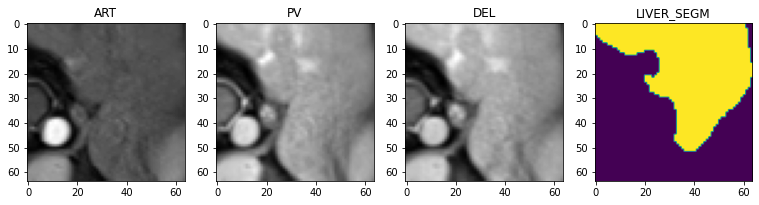

ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.21712613105773926
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.30218541622161865
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.30912157893180847


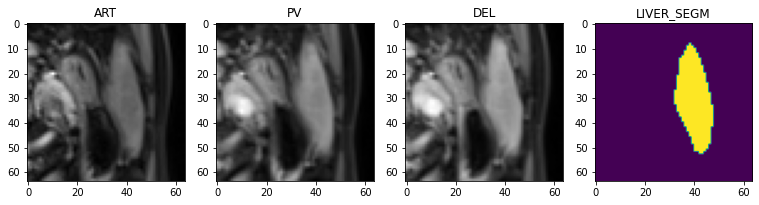

ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.3326471447944641
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.2904331088066101
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.2764236629009247


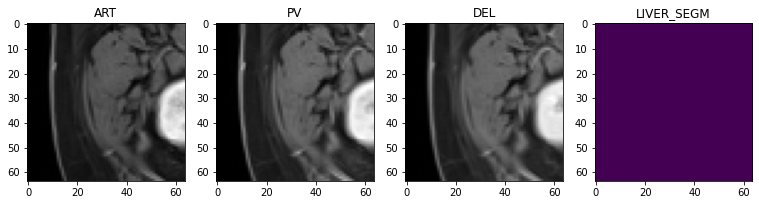

ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.027372539043426514
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.07987423241138458
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.07156602293252945


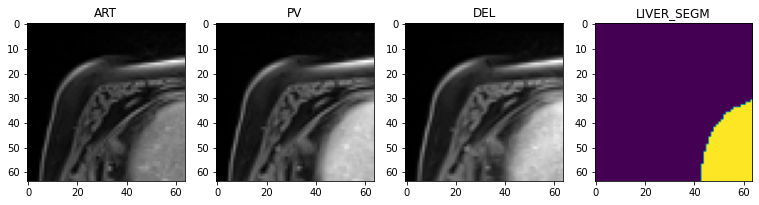

ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 1.2019355297088623
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 1.3678687810897827
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 1.2511597871780396


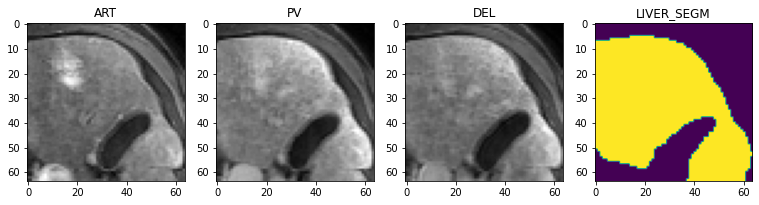

ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.5505027174949646
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.6006718277931213
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.5406556725502014


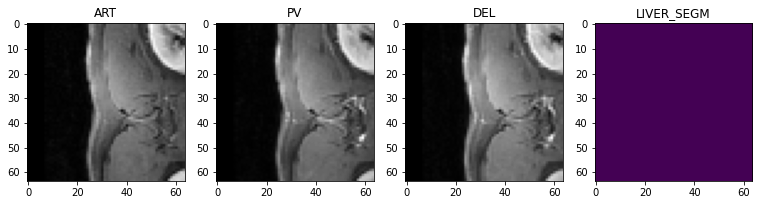

ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.2848072350025177
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.2815907895565033
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.26669955253601074


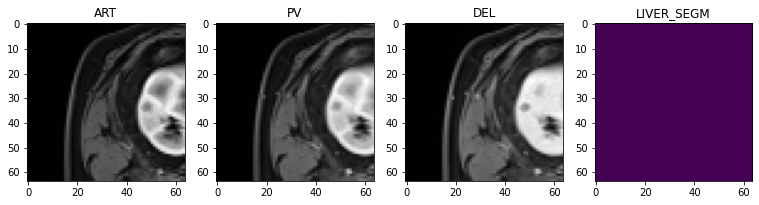

ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.703554630279541
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.705093264579773
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.648556113243103


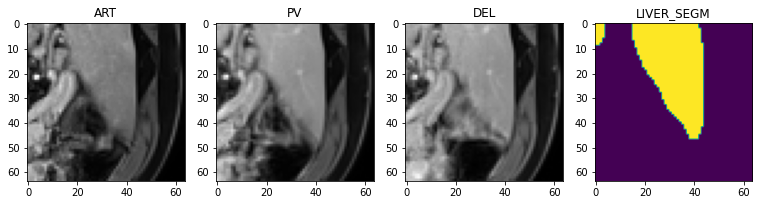

ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.73255455493927
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.6838058233261108
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.6174734234809875


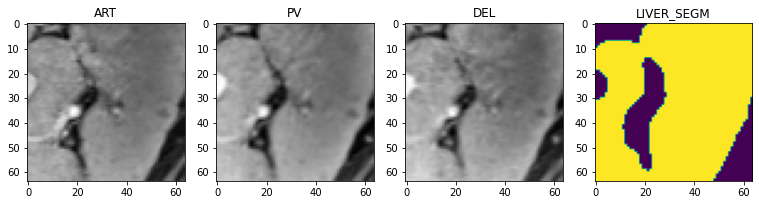

ART shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
ART mean: 0.8778724670410156
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.8216164708137512
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.7340983748435974


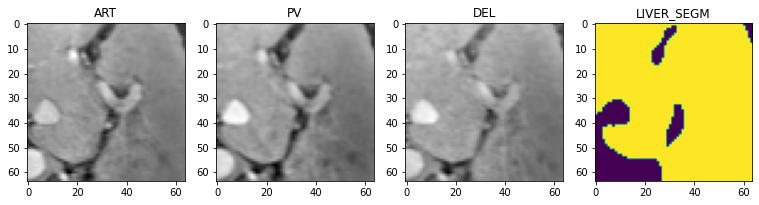

In [13]:
check_ds = monai.data.Dataset(data=train_data_dict[:10], transform=train_transforms)
#check_ds = monai.data.Dataset(data=val_data_dict[10:11], transform=val_transforms)
#check_ds = monai.data.Dataset(data=test_data_dict[:1], transform=test_transforms)

check_loader = DataLoader(check_ds, batch_size=10, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['ART'].shape)
print(check_data['PV'].shape)
print(check_data['DEL'].shape)


num_display = 10
if check_data['ART'].shape[0] < num_display:
    num_display = check_data['ART'].shape[0]

for i in range(num_display):
    ART, PV, DEL , liver_label = (check_data['ART'][i][0],check_data['PV'][i][0],check_data['DEL'][i][0], check_data['SEGM'][i][0])


    
    print('ART shape: {}, label shape: {}'.format(ART.shape, liver_label.shape))
    print('ART mean: {}'.format(np.mean(ART.numpy())))
    
    
    print('PV shape: {}, label shape: {}'.format(PV.shape, liver_label.shape))
    print('PV mean: {}'.format(np.mean(PV.numpy())))
    
    print('DEL shape: {}, label shape: {}'.format(DEL.shape, liver_label.shape))
    print('DEL mean: {}'.format(np.mean(DEL.numpy())))



    slice_num = ART.shape[2]//2
    
    plt.figure('check', (13, 15))

    plt.subplot(1, 4, 1)
    plt.title('ART')
    plt.imshow(ART[:,:,slice_num], cmap='gray')

 
    
    plt.subplot(1, 4, 2)
    plt.title('PV')
    plt.imshow(PV[:,:,slice_num], cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title('DEL')
    plt.imshow(DEL[:,:,slice_num], cmap='gray')
    
    plt.subplot(1, 4 ,4)
    plt.title('LIVER_SEGM')
    plt.imshow(liver_label[:,:,slice_num])
    
    plt.show()



    


## Create Segmentation Model (U-net)

In [14]:
class MRILiverSegmentation(pytorch_lightning.LightningModule):

    def __init__(self, dropout_rate = 0.0):
        super().__init__()
        
        self._model = monai.networks.nets.UNet(
            dimensions=3, 
            in_channels=3, 
            out_channels=2, 
            channels=(16, 32, 64, 128),
            strides=(2, 2, 2), 
            num_res_units=2, 
            norm=Norm.BATCH,
            dropout = dropout_rate,
        )

    
        self.loss_function = monai.losses.DiceLoss(include_background=False, to_onehot_y=True, softmax=True)
        self.one_hot_transform = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
        self.val_metric = DiceMetric(include_background=False)

        self.best_val_dice = None
        self.best_val_epoch = None
        
        
    def forward(self, x):
        return self._model(x)

    
    def prepare_data(self):
        # set deterministic training for reproducibility
        set_determinism(seed=0)
    
    
    def training_step(self, batch, batch_idx):

        art_images =  batch["ART"]
        pv_images =  batch["PV"]
        del_images =  batch["DEL"]
        
        images = torch.cat((art_images, pv_images, del_images) ,dim=1)
        labels = batch["SEGM"]

        
        
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        return {"loss": loss}
    
    
    def training_epoch_end(self, outputs):
        # Only add the graph at the first epoch
        if self.current_epoch==1:
            #sample_input = torch.rand((1,1,96,96,16))
            sample_input = torch.rand((1,3,64,64,32))
            self.logger.experiment.add_graph(
                MRILiverSegmentation(), 
                [sample_input])
        
        # Calculate the average loss
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Train/Loss', avg_loss, self.current_epoch)
    
    

    def validation_step(self, batch, batch_idx):
        
        
        art_images =  batch["ART"]
        pv_images =  batch["PV"]
        del_images =  batch["DEL"]

        
        images = torch.cat((art_images, pv_images, del_images) ,dim=1)
        labels = batch["SEGM"]
        
        
        #images = batch["IMAGE"]
        #labels = batch["SEGM"]

        #roi_size = (256, 256, 48)
        roi_size = (224, 224, 128)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)

        loss = self.loss_function(outputs, labels)

#         one_hot = monai.networks.utils.one_hot(labels, num_classes=3)
        argmax = torch.argmax(outputs, dim=1, keepdim=True)
        val_dice = self.val_metric(
            self.one_hot_transform(argmax), 
            self.one_hot_transform(labels)
        )
                
        if batch_idx<1:
            img2tensorboard.plot_2d_or_3d_image(data=images, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Input')
            img2tensorboard.plot_2d_or_3d_image(data=argmax, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Output')

        return {"val_loss": loss, "val_dice": val_dice}
    
    def validation_epoch_end(self, outputs):
        # Calculate the average loss
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_dice = torch.stack([x['val_dice'][0] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Val/Loss', avg_loss, self.current_epoch)
        self.logger.experiment.add_scalar('Val/Dice', avg_dice, self.current_epoch)
        
        self.log('val_loss', avg_loss)
        self.log('val_dice', avg_dice)

    
    def configure_optimizers(self):
        return torch.optim.Adam(self._model.parameters(), lr=1e-4)
    
    

In [15]:
from torchinfo import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MRILiverSegmentation()
#summary(model.to(device), [1,1,96,96,16])
summary(model.to(device), [1,3,64,64,32])

Layer (type:depth-idx)                                                           Output Shape              Param #
MRILiverSegmentation                                                             --                        --
├─UNet: 1-1                                                                      [1, 2, 64, 64, 32]        --
│    └─Sequential: 2-1                                                           [1, 2, 64, 64, 32]        --
│    │    └─ResidualUnit: 3-1                                                    [1, 16, 32, 32, 16]       9,618
│    │    └─SkipConnection: 3-2                                                  [1, 32, 32, 32, 16]       1,178,186
│    │    └─Sequential: 3-3                                                      [1, 2, 64, 64, 32]        1,845
Total params: 1,189,649
Trainable params: 1,189,649
Non-trainable params: 0
Total mult-adds (G): 1.70
Input size (MB): 1.57
Forward/backward pass size (MB): 45.22
Params size (MB): 4.76
Estimated Total Size (MB):

## Model Training

In [16]:
MODEL_ROOT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/ART-PV-DEL-Net/'


In [17]:
# initialise the LightningModule
model = MRILiverSegmentation(dropout_rate=0.3)

# set up loggers and checkpoints
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=os.path.join(MODEL_ROOT_PATH,'saved_model','logs')
)

lr_monitor = pytorch_lightning.callbacks.LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    dirpath=os.path.join(MODEL_ROOT_PATH,'saved_model'),
    filename="MRILiverSegmentation-{epoch:04d}-{val_loss:.2f}",
    monitor='val_loss',
    save_last=True,
    save_on_train_epoch_end=True,
    save_top_k=2,
    mode='min'
)

# check for last checkpoint
resume_checkpoint = None
if os.path.exists(os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')):
    resume_checkpoint = os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=2000,
    logger=tb_logger,
    callbacks=[lr_monitor,checkpoint_callback],
    num_sanity_val_steps=1,
    check_val_every_n_epoch=20,
    resume_from_checkpoint=resume_checkpoint
)

# train
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:45: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:730: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1893: LightningDeprecationWarning: `trainer.resume_from_checkpoint` is deprecated in v1.5 and will be removed in v1.7. Specify the fit ch

Validation sanity check: 0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 7. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


## Model Testing

In [17]:
model_path = os.path.join(MODEL_ROOT_PATH,'saved_model','MRILiverSegmentation-epoch=1040-val_loss=0.08.ckpt')

In [18]:
model = MRILiverSegmentation.load_from_checkpoint(model_path)
# model.load_from_checkpoint(model_path)
model.eval()
device = torch.device("cuda:0")
model.to(device)

MRILiverSegmentation(
  (_model): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit1): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
        )
        (residual): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (1): SkipConnection(
        

In [19]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import torch
import time


from monai.transforms import KeepLargestConnectedComponent
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm
from monai.data import decollate_batch




def compute_evaluation_metrics(y_pred, y, keep=False):
    
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95, get_not_nans=False)
    mad = monai.metrics.SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep_largest = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    dice_list = list()
    hd_list = list()
    mad_list = list()
    for y_pred_i, y_i in decollate_batch((y_pred, y)):
        if keep:
            dice(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            hd(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            mad(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
        else:
                
            # Calculate Dice on the raw output
            dice(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            hd(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            mad(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            
            
        dice_value = dice.aggregate().item()
        hd_value = hd.aggregate().item()
        mad_value = mad.aggregate().item()
        
        print(dice_value)
        print(hd_value)
        print(mad_value)
        
        dice_list.append(dice_value)
        hd_list.append(hd_value)
        mad_list.append(mad_value)
              
    return dice_list, hd_list, mad_list


def run_inference_and_evaluate(model, data_loader, plot_images=False, max_eval=None, 
                               save_output=False,roi_size=(224,224,128), sw_batch_size=4, output_path=None):
    
    """Inference and evaluation function for Liver segmentation.
    
    """   
    
    df_eval = pd.DataFrame()
    
    acc_ids = list()
    input_paths = list()
    output_paths = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()
    


    
    # Use MONAI one_hot transform
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
        # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            #print(test_data['ACCESSION_ID'][0])
            #for val in test_data['ACCESSION_ID'][0]:
            #    acc_ids.append(val)

    
            art_images =  test_data["ART"].to(device)
            pv_images =  test_data["PV"].to(device)
            del_images =  test_data["DEL"].to(device)

            x = torch.cat((art_images, pv_images, del_images) ,dim=1)
            y = test_data['SEGM'].cpu()




            start_time = time.time()
            y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
            stop_time = time.time()

            inference_time = stop_time-start_time
            inference_times.append(inference_time)

            x = x.detach().cpu()
            y_pred = y_pred.detach().cpu()
            #print(y_pred.shape)

            #argmax = torch.argmax(y_pred, dim=1, keepdim=True)
            #argmax = argmax.detach().cpu()

            #y_onehot = one_hot(y)
            #y_pred_onehot = one_hot(argmax)

            # Evaluate segmentation metrics
            eval_list = list()
            # Update to MONAI 0.7+
            dice_values, hd_values, mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y
            )

            for val in dice_values:
                original_dice_results.append(val)
            for val in hd_values:
                original_hd_results.append(val)
            for val in mad_values:
                original_mad_results.append(val)



            post_dice_values, post_hd_values, post_mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y, keep=True
            )        #dice_list = list()
            #post_dice_list = list()

            for val in post_dice_values:
                postprocess_dice_results.append(val)
            for val in post_hd_values:
                postprocess_hd_results.append(val)
            for val in post_mad_values:
                postprocess_mad_results.append(val)





            print(y_pred.shape)
            print(argmax(y_pred[0,...]).shape)


            if plot_images:
                art_img = art_images.detach().cpu()
                pv_img = pv_images.detach().cpu()
                del_img = del_images.detach().cpu()



                slice_num = x.shape[-1]//2

                plt.figure('check', (9, 3))
                plt.subplot(1, 5, 1)
                plt.title('ART')
                plt.imshow(art_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 5, 2)
                plt.title('PV')
                plt.imshow(pv_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 5, 3)
                plt.title('DEL')
                plt.imshow(del_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 5, 4)
                plt.title('SEGM')
                plt.imshow(y[0,0,:,:,slice_num])

                plt.subplot(1, 5, 5)
                plt.title('PRED')
                plt.imshow(argmax(y_pred[0,...])[0,:,:,slice_num])
                plt.show()


            # Write data out
            if save_output:
                # Get the image affine matrix
                current_affine = test_data['ART_meta_dict']['affine'][0].numpy()
                original_affine = test_data['ART_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['ART_meta_dict']['spatial_shape'][0].numpy()

                input_file_name = test_data['ART_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                output_path_final = os.path.join(output_path,'{}_segm.nii.gz'.format(output_root_name))
                print('Saving segmentation results: {}'.format(output_path_final))
                
                output_paths.append(output_path_final)
                
                #output_segm = argmax.cpu()[0, 0,...].numpy()
                output_segm = keep(argmax(y_pred[0,...])).cpu()[0,...].numpy()
                write_nifti(output_segm, output_path_final,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

    
    #df_eval['ACCESSION_ID'] = acc_ids
    #df_eval['PV'] = input_paths
    df_eval['DICE'] = original_dice_results
    print(original_dice_results)
    df_eval['POST_DICE'] = postprocess_dice_results
    df_eval['HD95'] = original_hd_results
    df_eval['POST_HD95'] = postprocess_hd_results
    #df_eval['MAD'] = original_mad_results
    #df_eval['POST_MAD'] = postprocess_mad_results
    df_eval['InferenceTime'] = inference_times
    if output_path is not None:
        df_eval['AUTOMATED-LIVER-SEGM'] = output_paths    
    return df_eval


In [20]:
OUTPUT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL'

0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarni

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 195 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 195 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 196 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Use

0.9691531658172607
1.0571697902425021
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 184 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 185 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 186 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning

0.9691548347473145
1.0571697902425021
inf
torch.Size([1, 2, 201, 151, 108])
torch.Size([1, 201, 151, 108])


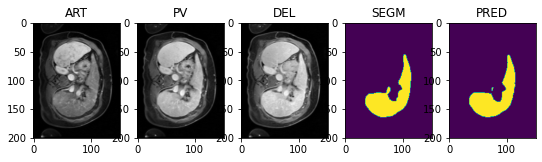

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E100998852_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 48 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 49 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 50 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

0.9734927415847778
4.580656401916622
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 49 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 50 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 51 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: t

0.9777712821960449
1.4018096544368572
inf
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])


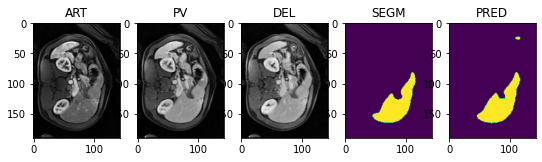

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/12370686_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 66 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 67 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 68 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 66 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 67 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 68 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarnin

0.9482581615447998
7.2538727330208355
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 66 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 67 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 68 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: t

0.9708804488182068
1.1019712958327952
0.3099014422583807
torch.Size([1, 2, 220, 177, 120])
torch.Size([1, 220, 177, 120])


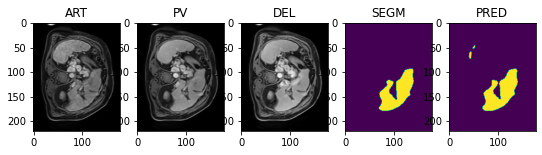

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E104184251_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 219 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 219 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 220 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Use

0.9255188703536987
36.09012655083775
inf
0.9710040092468262
1.5095951350080508
inf
torch.Size([1, 2, 230, 230, 144])
torch.Size([1, 230, 230, 144])


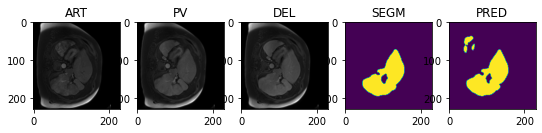

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E100353838_T1_ART_segm.nii.gz
0.96619713306427
1.8011473286639812
0.4706330260982374
0.9663183689117432
1.5784127174887381
0.3683305191635544
torch.Size([1, 2, 210, 158, 95])
torch.Size([1, 210, 158, 95])


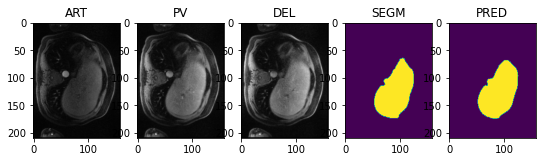

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/11655071_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 161 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 161 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 162 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Use

0.9582327604293823
1.1827550916328704
inf
0.9582327604293823
1.1827550916328704
inf
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


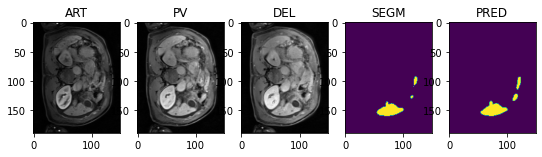

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E105258820_T1_ART_segm.nii.gz
0.9711110591888428
6.982913283631952
inf
0.9722908735275269
1.4158741774866994
inf
torch.Size([1, 2, 180, 169, 140])
torch.Size([1, 180, 169, 140])


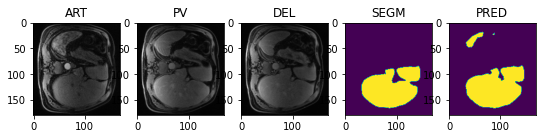

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/10782833_T1_ART_segm.nii.gz
0.9834862947463989
0.9618196805176664
inf
0.9834868907928467
0.9618196805176664
inf
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


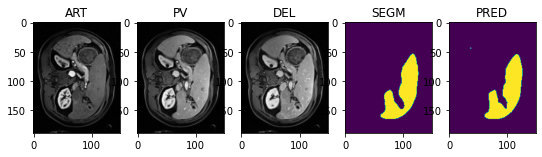

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E105047582_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 157 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 158 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 158 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Use

0.9575850963592529
2.215107826324849
inf
0.9577078223228455
1.5323188816012312
inf
torch.Size([1, 2, 200, 156, 120])
torch.Size([1, 200, 156, 120])


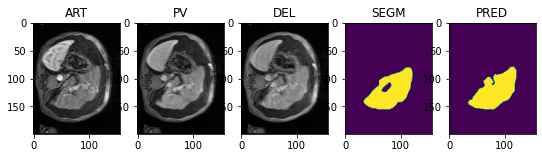

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E100559269_T1_ART_segm.nii.gz
0.8767755031585693
13.364188210792895
inf
0.8767819404602051
13.358934225506355
inf
torch.Size([1, 2, 180, 147, 132])
torch.Size([1, 180, 147, 132])


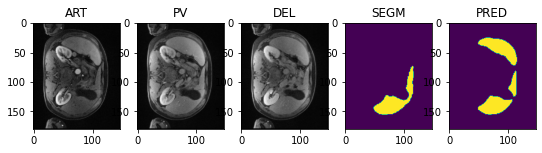

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/11157922_T1_ART_segm.nii.gz
0.970361590385437
2.1078984028649272
0.38167412848024773
0.970361590385437
2.1078984028649272
0.38167412848024773
torch.Size([1, 2, 203, 172, 116])
torch.Size([1, 203, 172, 116])


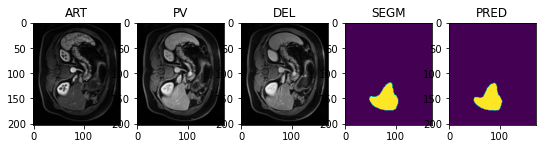

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E103977998_T1_ART_segm.nii.gz
0.9716079235076904
1.4841081255921127
inf
0.9717512130737305
1.475510241994229
inf
torch.Size([1, 2, 190, 155, 120])
torch.Size([1, 190, 155, 120])


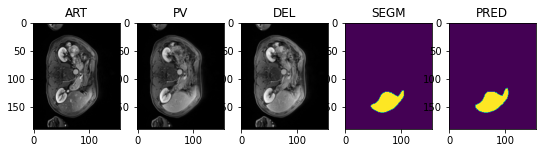

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E106605970_T1_ART_segm.nii.gz
0.9315694570541382
13.469454066752
inf
0.9530949592590332
4.358562828880268
inf
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])


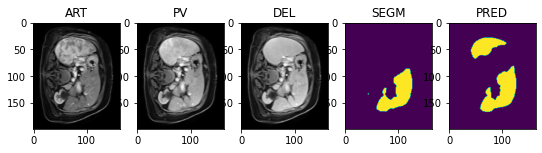

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E101166449_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 77 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 77 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 78 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWa

0.9679044485092163
4.198162862714582
inf
0.9683820009231567
2.1205492263509464
0.31359660818484514
torch.Size([1, 2, 221, 221, 110])
torch.Size([1, 221, 221, 110])


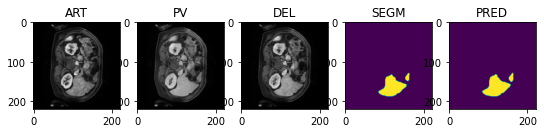

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E101693803_T1_ART_segm.nii.gz
0.9619146585464478
4.423799097330127
inf
0.9696632623672485
1.1782505413379254
inf
torch.Size([1, 2, 205, 160, 120])
torch.Size([1, 205, 160, 120])


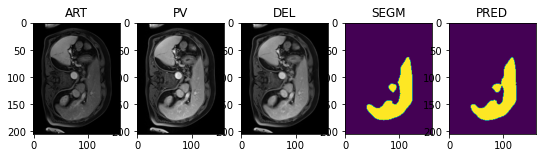

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E100488381_T1_ART_segm.nii.gz
0.9555377960205078
2.9540594782432223
inf
0.9555377960205078
2.9540594782432223
inf
torch.Size([1, 2, 225, 176, 132])
torch.Size([1, 225, 176, 132])


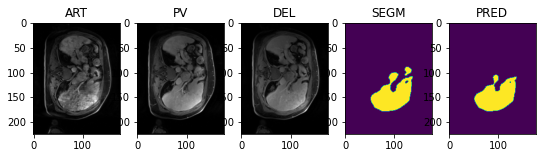

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E101446184_T1_ART_segm.nii.gz
0.9261969327926636
2.106688257225109
inf
0.9262142777442932
2.106688257225109
inf
torch.Size([1, 2, 190, 127, 108])
torch.Size([1, 190, 127, 108])


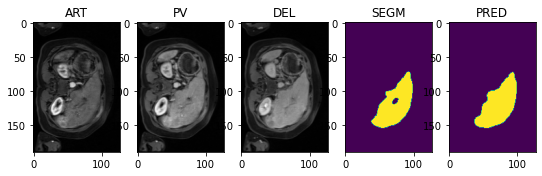

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/12132879_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 85 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 85 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 86 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWa

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 85 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 85 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 86 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: t

0.9637141227722168
1.1080834528916552
inf
0.9637141227722168
1.1080834528916552
inf
torch.Size([1, 2, 250, 187, 132])
torch.Size([1, 250, 187, 132])


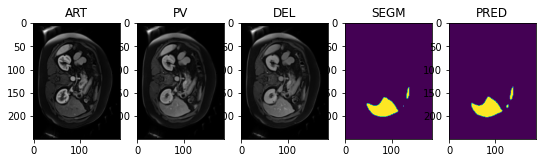

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E100207522_T1_ART_segm.nii.gz
0.948438823223114
11.630154218228892
inf
0.9713491201400757
1.3668440352169882
inf
torch.Size([1, 2, 210, 169, 120])
torch.Size([1, 210, 169, 120])


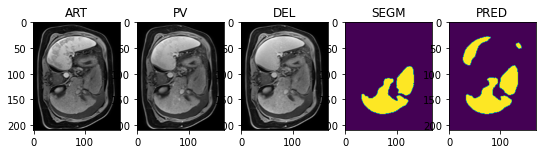

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E104350920_T1_ART_segm.nii.gz
0.9674832820892334
3.523646368473305
inf
0.968564510345459
1.6103370978097282
inf
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])


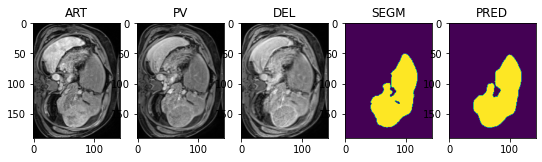

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E103442524_T1_ART_segm.nii.gz
0.9681332111358643
4.627843906506602
inf
0.9688869118690491
1.793199829280995
0.3578206281216259
torch.Size([1, 2, 210, 210, 132])
torch.Size([1, 210, 210, 132])


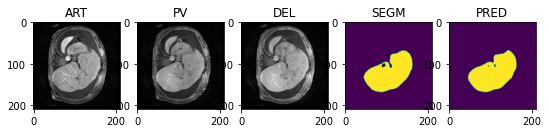

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E100354995_T1_ART_segm.nii.gz
0.9720460176467896
5.201680489516953
inf
0.9734008312225342
1.3891176754465995
0.32860490797672104
torch.Size([1, 2, 200, 157, 120])
torch.Size([1, 200, 157, 120])


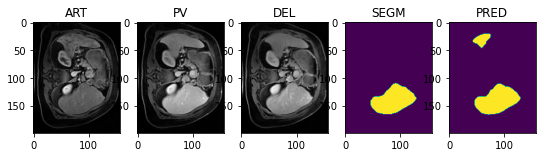

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/12169194_T1_ART_segm.nii.gz
0.9507687091827393
3.6561565581470177
inf
0.9523019790649414
1.199182873936492
inf
torch.Size([1, 2, 191, 191, 88])
torch.Size([1, 191, 191, 88])


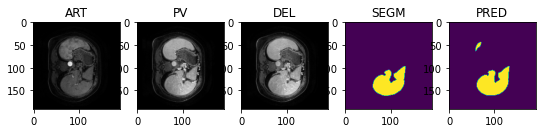

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/9464709_T1_ART_segm.nii.gz
0.9760717153549194
2.716107062280497
inf
0.9766695499420166
0.9690616077350437
0.26120290221073766
torch.Size([1, 2, 221, 221, 144])
torch.Size([1, 221, 221, 144])


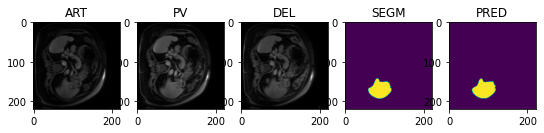

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E102885531_T1_ART_segm.nii.gz
0.9728080034255981
1.5659926683991663
inf
0.9728348255157471
1.514987643273543
inf
torch.Size([1, 2, 200, 163, 108])
torch.Size([1, 200, 163, 108])


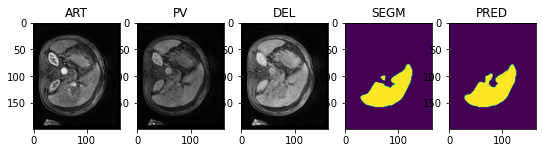

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E106731917_T1_ART_segm.nii.gz
0.9741299152374268
3.0204282913133707
inf
0.9741299152374268
3.0204282913133707
inf
torch.Size([1, 2, 211, 211, 131])
torch.Size([1, 211, 211, 131])


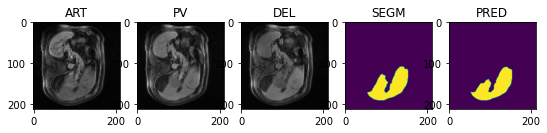

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E105877173_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 155 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 155 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 156 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Use

0.9630217552185059
3.5549497563790347
inf
0.9686287641525269
1.2369740662386248
0.31305594206540416
torch.Size([1, 2, 175, 143, 108])
torch.Size([1, 175, 143, 108])


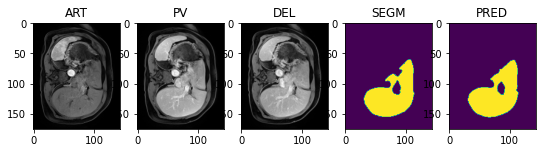

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E106096969_T1_ART_segm.nii.gz
0.9681999683380127
1.4129362094825546
inf
0.9681999683380127
1.4129362094825546
inf
torch.Size([1, 2, 190, 184, 120])
torch.Size([1, 190, 184, 120])


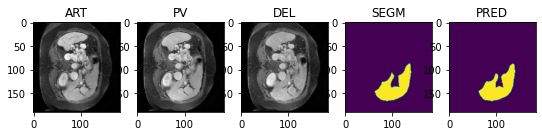

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/11571840_T1_ART_segm.nii.gz
0.9696558713912964
1.2272892724295974
inf
0.9696558713912964
1.2272892724295974
inf
torch.Size([1, 2, 220, 165, 131])
torch.Size([1, 220, 165, 131])


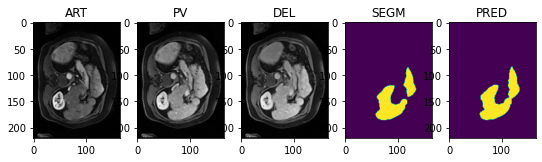

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E101753253_T1_ART_segm.nii.gz
0.971706748008728
1.0581030192298477
inf
0.971706748008728
1.0581030192298477
inf
torch.Size([1, 2, 190, 155, 120])
torch.Size([1, 190, 155, 120])


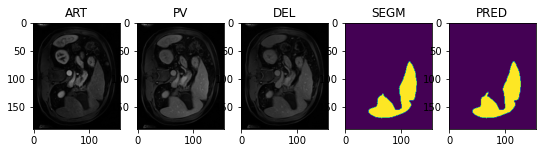

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E103922902_T1_ART_segm.nii.gz
0.9703969955444336
5.388259593622359
inf
0.9713551998138428
1.815891172569728
0.4028367079892908
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


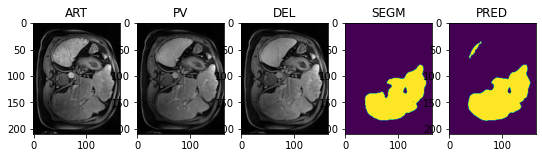

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E101453378_T1_ART_segm.nii.gz
0.9632605314254761
1.960733015636773
inf
0.9632613658905029
1.959497653985981
inf
torch.Size([1, 2, 180, 146, 102])
torch.Size([1, 180, 146, 102])


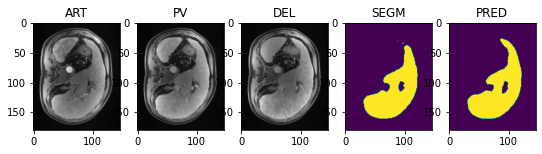

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/11397044_T1_ART_segm.nii.gz
0.9524024724960327
6.487066091453904
inf
0.9618947505950928
1.5296864696175825
inf
torch.Size([1, 2, 210, 158, 120])
torch.Size([1, 210, 158, 120])


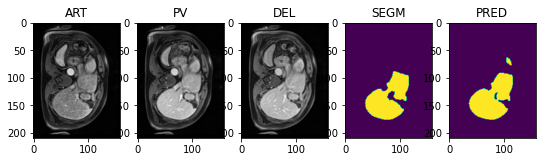

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/12922235_T1_ART_segm.nii.gz
0.9769778251647949
1.3135029513992629
inf
0.9769778251647949
1.3135029513992629
inf
torch.Size([1, 2, 185, 151, 120])
torch.Size([1, 185, 151, 120])


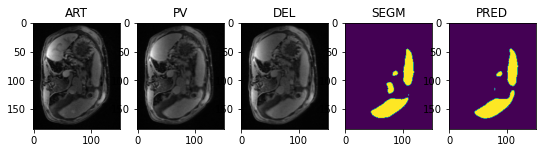

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/10939089_T1_ART_segm.nii.gz
0.9637154340744019
1.2378803792391984
inf
0.9637154340744019
1.2378803792391984
inf
torch.Size([1, 2, 225, 149, 144])
torch.Size([1, 225, 149, 144])


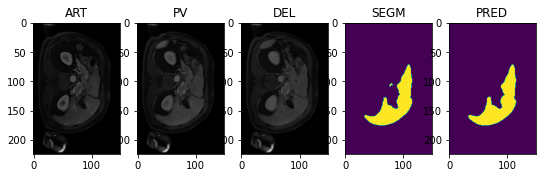

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/12957044_T1_ART_segm.nii.gz
0.9753381013870239
5.468245314965766
1.0403403302203145
0.977649450302124
1.4730834489924252
0.36958112896770623
torch.Size([1, 2, 220, 179, 120])
torch.Size([1, 220, 179, 120])


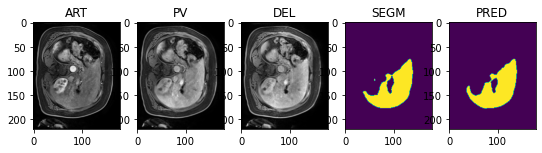

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E107891018_T1_ART_segm.nii.gz
0.9751772880554199
4.51122801407348
inf
0.9763711094856262
1.2227280140734809
inf
torch.Size([1, 2, 201, 151, 132])
torch.Size([1, 201, 151, 132])


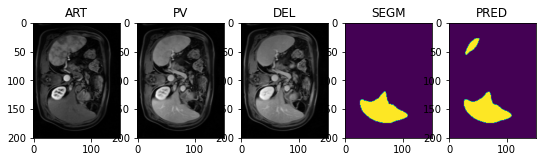

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E104332583_T1_ART_segm.nii.gz
0.9721943736076355
2.382401483307711
inf
0.9723571538925171
0.9548900677825976
inf
torch.Size([1, 2, 220, 165, 144])
torch.Size([1, 220, 165, 144])


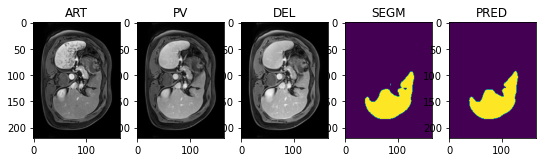

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E101547088_T1_ART_segm.nii.gz
0.96113121509552
1.1374300670800286
inf
0.9611378908157349
1.1374300670800286
inf
torch.Size([1, 2, 195, 147, 139])
torch.Size([1, 195, 147, 139])


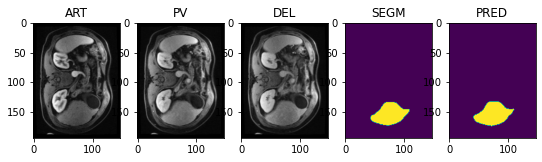

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/11524268_T1_ART_segm.nii.gz
0.9754045009613037
2.856123959443755
inf
0.9756484031677246
1.5677870357479626
inf
torch.Size([1, 2, 190, 155, 132])
torch.Size([1, 190, 155, 132])


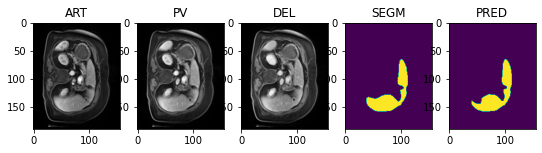

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E106458466_T1_ART_segm.nii.gz
0.9520190954208374
2.4833149712168843
inf
0.9520912170410156
2.097728236523007
inf
torch.Size([1, 2, 197, 160, 96])
torch.Size([1, 197, 160, 96])


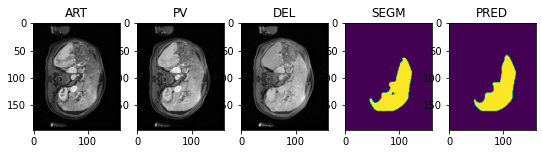

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E107235152_T1_ART_segm.nii.gz
0.9465491771697998
7.875438815752512
inf
0.9660525321960449
1.8111186449344447
0.4644989848212761
torch.Size([1, 2, 201, 201, 123])
torch.Size([1, 201, 201, 123])


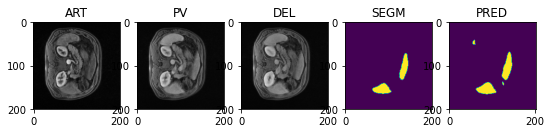

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E105198762_T1_ART_segm.nii.gz
0.9434505701065063
8.323373854264862
inf
0.9443323612213135
6.420463830948107
inf
torch.Size([1, 2, 190, 164, 144])
torch.Size([1, 190, 164, 144])


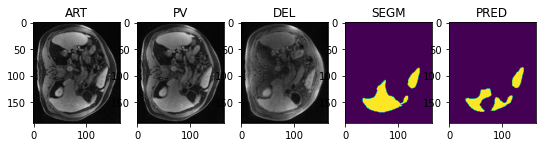

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/11148247_T1_ART_segm.nii.gz
0.9736065864562988
1.7159191978544601
inf
0.9736331701278687
1.592842274777537
0.3667281857029775
torch.Size([1, 2, 196, 192, 120])
torch.Size([1, 196, 192, 120])


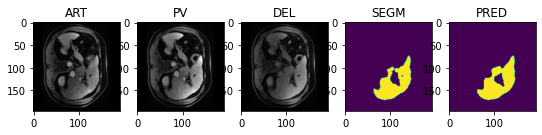

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E106751045_T1_ART_segm.nii.gz
0.953291118144989
2.1003914948355598
0.45809682989458383
0.953291118144989
2.1003914948355598
0.45809682989458383
torch.Size([1, 2, 186, 186, 92])
torch.Size([1, 186, 186, 92])


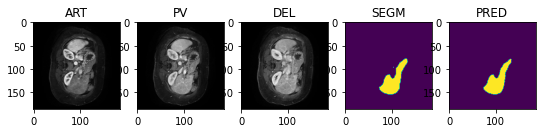

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/9648994_T1_ART_segm.nii.gz
0.9675222039222717
2.7276777624084505
inf
0.9675923585891724
1.5599528946835903
inf
torch.Size([1, 2, 190, 148, 142])
torch.Size([1, 190, 148, 142])


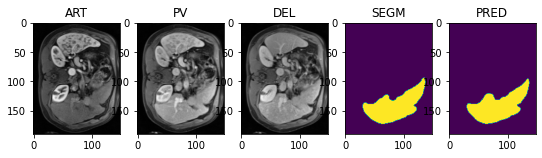

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E102928841_T1_ART_segm.nii.gz
0.9660437107086182
1.676171504032648
inf
0.966127872467041
1.2174458397752852
inf
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])


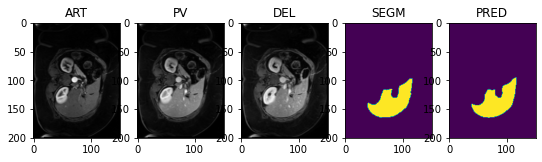

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E105426183_T1_ART_segm.nii.gz
0.9772085547447205
3.6407993143565798
inf
0.977750301361084
1.0994100875174821
inf
torch.Size([1, 2, 200, 163, 116])
torch.Size([1, 200, 163, 116])


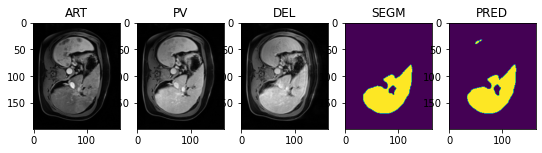

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E100142484_T1_ART_segm.nii.gz
0.9793415069580078
1.3893732250068778
inf
0.9793415069580078
1.3893732250068778
inf
torch.Size([1, 2, 190, 155, 132])
torch.Size([1, 190, 155, 132])


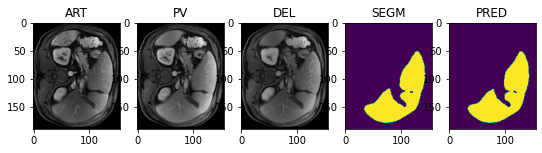

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E105829099_T1_ART_segm.nii.gz
0.941705584526062
5.737093468294175
inf
0.9419999122619629
3.3389684682941745
inf
torch.Size([1, 2, 201, 201, 92])
torch.Size([1, 201, 201, 92])


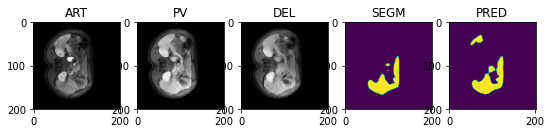

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/9586289_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 142 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 142 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 143 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Use

0.8345931768417358
16.072148299044112
inf
0.8345931768417358
16.072148299044112
inf
torch.Size([1, 2, 170, 133, 108])
torch.Size([1, 170, 133, 108])


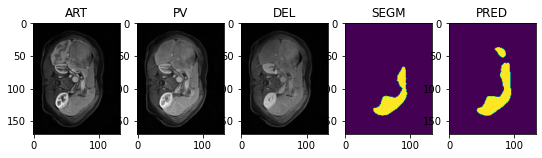

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E107156072_T1_ART_segm.nii.gz
0.9520952701568604
5.093565259246492
inf
0.9749633073806763
1.0152586652397986
inf
torch.Size([1, 2, 220, 174, 108])
torch.Size([1, 220, 174, 108])


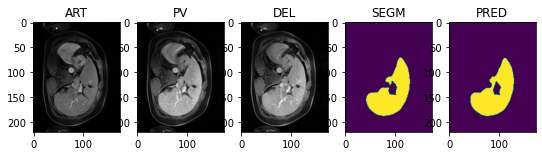

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E104998309_T1_ART_segm.nii.gz
0.9485775232315063
9.149235148415018
inf
0.9609213471412659
1.5301954943764668
inf
torch.Size([1, 2, 200, 173, 120])
torch.Size([1, 200, 173, 120])


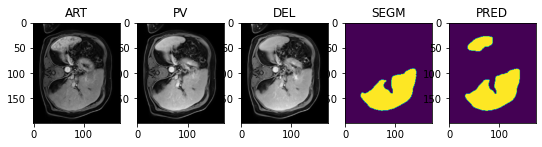

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E105615985_T1_ART_segm.nii.gz
0.981047511100769
1.0009066731008678
inf
0.981047511100769
1.0009066731008678
inf
torch.Size([1, 2, 190, 149, 132])
torch.Size([1, 190, 149, 132])


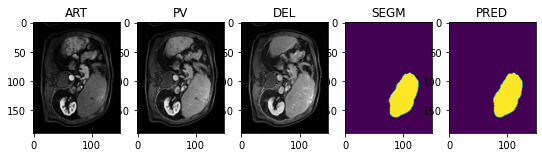

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/12916368_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 88 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 89 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 90 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 88 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 89 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 90 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarnin

0.9660502672195435
1.951946129202107
inf
0.9660636186599731
1.951946129202107
inf
torch.Size([1, 2, 211, 181, 116])
torch.Size([1, 211, 181, 116])


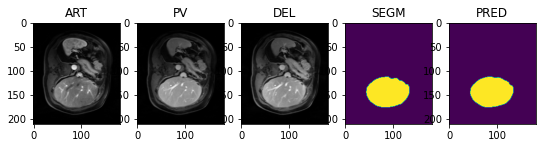

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E103814356_T1_ART_segm.nii.gz
0.9661112427711487
2.852468338528633
inf
0.9661112427711487
2.852468338528633
inf
torch.Size([1, 2, 170, 144, 150])
torch.Size([1, 170, 144, 150])


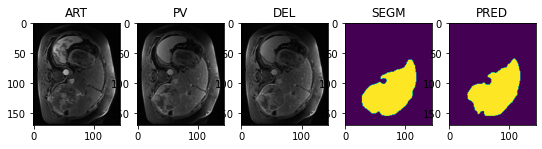

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/11022925_T1_ART_segm.nii.gz
0.9692755937576294
1.6649964631243477
inf
0.9693357944488525
1.1013379265389862
inf
torch.Size([1, 2, 206, 206, 110])
torch.Size([1, 206, 206, 110])


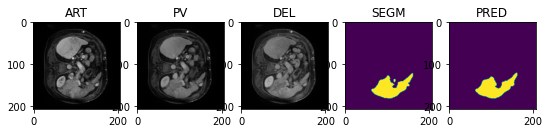

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E106533478_T1_ART_segm.nii.gz
0.9722804427146912
1.3845468711767244
0.3227675315420624
0.9722804427146912
1.3845468711767244
0.3227675315420624
torch.Size([1, 2, 191, 143, 132])
torch.Size([1, 191, 143, 132])


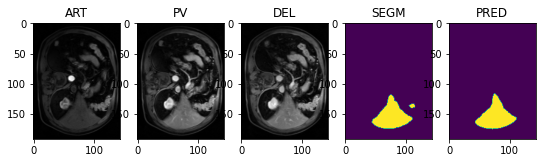

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E106851724_T1_ART_segm.nii.gz
0.9290024042129517
17.493176374360168
inf
0.9384779930114746
2.6506447412012806
inf
torch.Size([1, 2, 181, 181, 135])
torch.Size([1, 181, 181, 135])


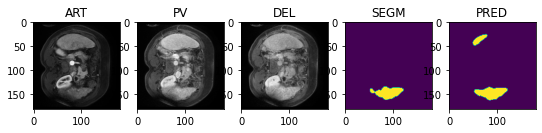

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E103511968_T1_ART_segm.nii.gz
0.9768332242965698
2.1866813190800443
inf
0.9769206047058105
1.070209356463224
0.2820969153764321
torch.Size([1, 2, 215, 173, 120])
torch.Size([1, 215, 173, 120])


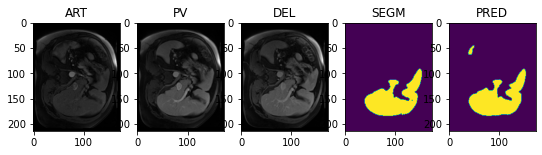

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E107553107_T1_ART_segm.nii.gz
0.9668842554092407
1.4812906474625382
0.3022959675325065
0.9668842554092407
1.4812906474625382
0.3022959675325065
torch.Size([1, 2, 201, 151, 111])
torch.Size([1, 201, 151, 111])


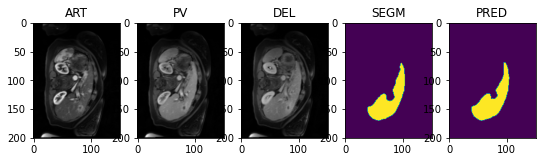

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E100588448_T1_ART_segm.nii.gz
0.9602826833724976
1.9711231487873968
inf
0.9603270292282104
1.9461775431216168
inf
torch.Size([1, 2, 236, 232, 120])
torch.Size([1, 236, 232, 120])


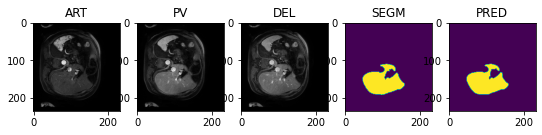

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E104134228_T1_ART_segm.nii.gz
0.9561012983322144
1.8156755569250547
inf
0.9561108946800232
1.8156755569250547
inf
torch.Size([1, 2, 211, 211, 110])
torch.Size([1, 211, 211, 110])


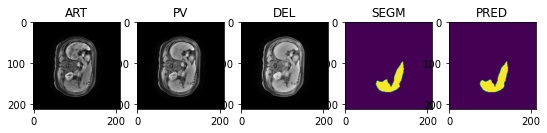

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E101686218_T1_ART_segm.nii.gz
0.920619785785675
3.4203974144690585
inf
0.920665979385376
2.7776940651867665
inf
torch.Size([1, 2, 210, 181, 108])
torch.Size([1, 210, 181, 108])


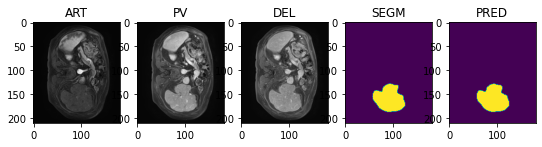

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E100967188_T1_ART_segm.nii.gz
0.9736005067825317
1.7103867186869328
inf
0.9736522436141968
1.2029090401155043
inf
torch.Size([1, 2, 225, 181, 131])
torch.Size([1, 225, 181, 131])


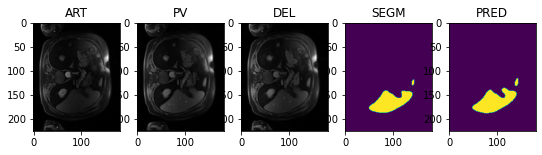

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E107476766_T1_ART_segm.nii.gz
0.9203836917877197
12.357164590042784
inf
0.9480450749397278
1.2306800305105587
inf
torch.Size([1, 2, 200, 161, 115])
torch.Size([1, 200, 161, 115])


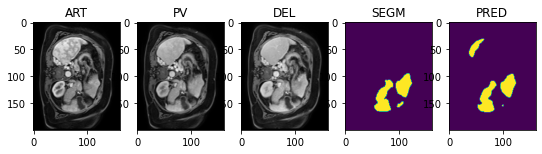

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E104250009_T1_ART_segm.nii.gz
0.9805445671081543
3.2656510564542667
inf
0.9808293581008911
1.116027940876377
0.24232747232425075
torch.Size([1, 2, 200, 156, 132])
torch.Size([1, 200, 156, 132])


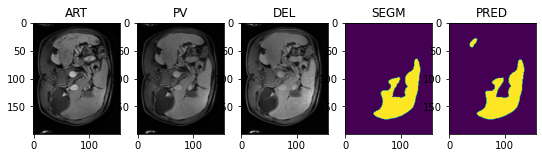

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E105152299_T1_ART_segm.nii.gz
0.9496304988861084
6.783288135130052
inf
0.9560282230377197
1.271147828735929
inf
torch.Size([1, 2, 192, 192, 108])
torch.Size([1, 192, 192, 108])


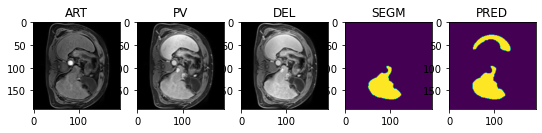

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/11308203_T1_ART_segm.nii.gz
0.9786992073059082
1.0164778492554358
inf
0.9786992073059082
1.0164778492554358
inf
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])


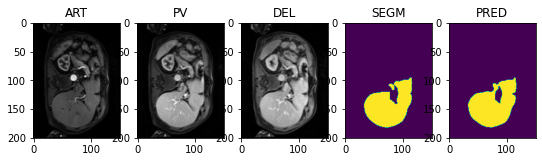

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E107046127_T1_ART_segm.nii.gz
0.9681620001792908
1.3313002674362757
inf
0.9681645035743713
1.3313002674362757
inf
torch.Size([1, 2, 230, 180, 120])
torch.Size([1, 230, 180, 120])


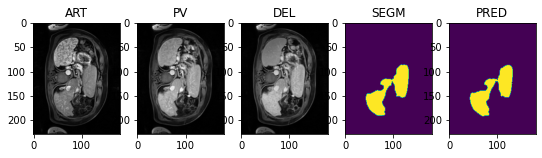

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/13106408_T1_ART_segm.nii.gz
0.9793518781661987
0.9397547112276048
inf
0.9793518781661987
0.9397547112276048
inf
torch.Size([1, 2, 210, 158, 120])
torch.Size([1, 210, 158, 120])


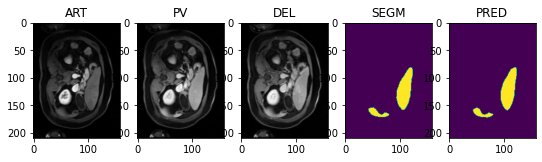

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E102486953_T1_ART_segm.nii.gz


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 141 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 141 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")


0.8512444496154785
15.963657797328693
inf
0.8734146356582642
9.18086528409632
inf
torch.Size([1, 2, 170, 149, 120])
torch.Size([1, 170, 149, 120])


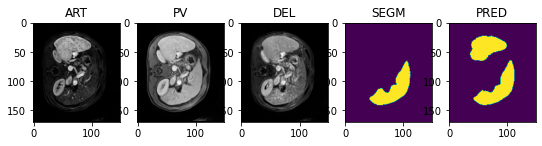

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E101055640_T1_ART_segm.nii.gz
0.973371148109436
4.824168038078682
inf
0.973371148109436
4.824168038078682
inf
torch.Size([1, 2, 200, 137, 120])
torch.Size([1, 200, 137, 120])


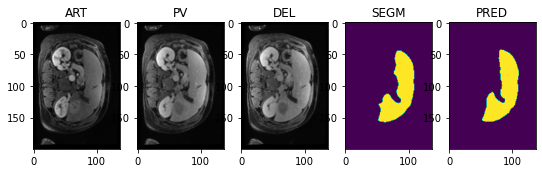

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/10807315_T1_ART_segm.nii.gz
0.9790025949478149
5.108092739151563
inf
0.9822112321853638
1.210949896109286
0.24544608430656684
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


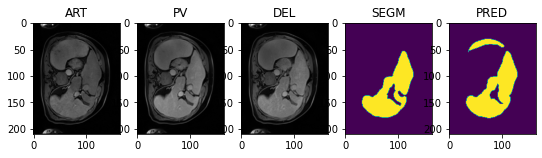

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/13170972_T1_ART_segm.nii.gz
0.9510048031806946
9.046548279759353
inf
0.9533435106277466
3.657720112869346
inf
torch.Size([1, 2, 205, 154, 155])
torch.Size([1, 205, 154, 155])


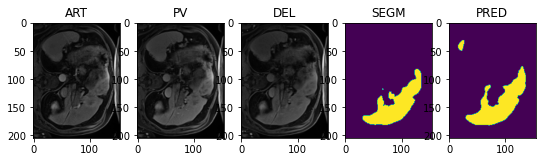

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E104594843_T1_ART_segm.nii.gz
0.9763066172599792
3.3557522137523295
inf
0.9775880575180054
1.3033922529121307
0.30279491818066506
torch.Size([1, 2, 231, 231, 144])
torch.Size([1, 231, 231, 144])


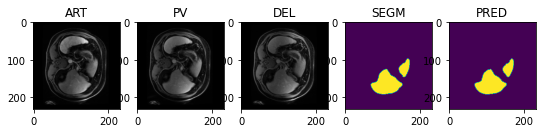

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E104034609_T1_ART_segm.nii.gz
0.9708492755889893
7.682726672492076
inf
0.9762941598892212
0.9316507941928192
inf
torch.Size([1, 2, 191, 141, 120])
torch.Size([1, 191, 141, 120])


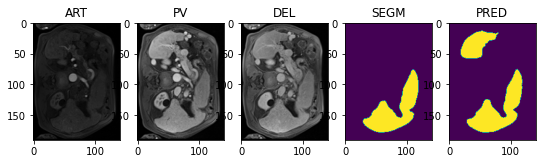

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E107774979_T1_ART_segm.nii.gz
0.9609180092811584
1.5628806890845666
inf
0.9609180092811584
1.5628806890845666
inf
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


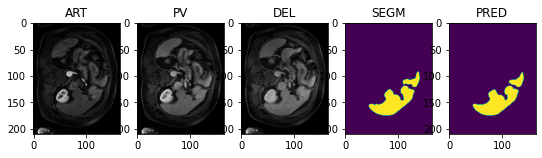

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E104900599_T1_ART_segm.nii.gz
0.9810171127319336
2.9437926830692787
inf
0.981148362159729
1.1656267442046497
inf
torch.Size([1, 2, 230, 180, 142])
torch.Size([1, 230, 180, 142])


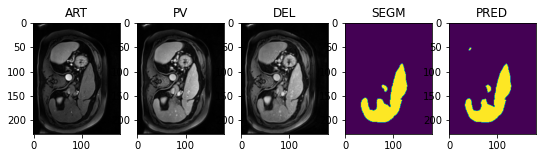

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E104657225_T1_ART_segm.nii.gz
0.9598144292831421
5.7636938848726755
inf
0.9617390632629395
2.130174331800052
inf
torch.Size([1, 2, 180, 135, 108])
torch.Size([1, 180, 135, 108])


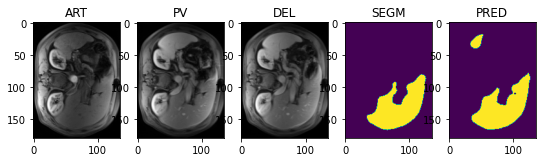

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E105599954_T1_ART_segm.nii.gz
0.965533435344696
6.60825876129734
inf
0.9655444622039795
6.60825876129734
inf
torch.Size([1, 2, 235, 183, 132])
torch.Size([1, 235, 183, 132])


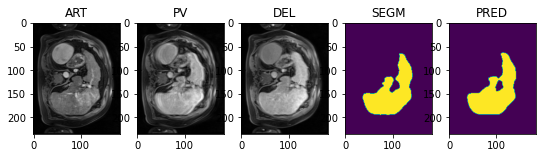

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E103570649_T1_ART_segm.nii.gz
0.96843421459198
4.048645527670722
inf
0.9709351062774658
1.568755320427294
inf
torch.Size([1, 2, 200, 156, 127])
torch.Size([1, 200, 156, 127])


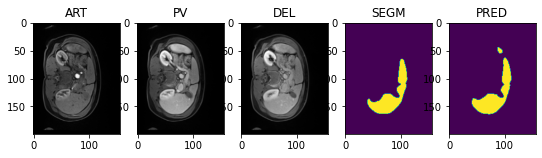

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E105504009_T1_ART_segm.nii.gz
0.9767104387283325
1.4093479407896892
inf
0.9767278432846069
1.4093479407896892
inf
torch.Size([1, 2, 211, 152, 104])
torch.Size([1, 211, 152, 104])


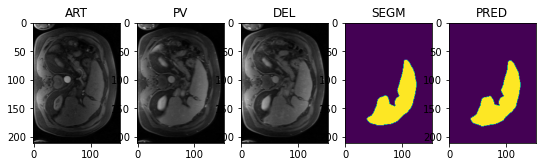

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E103831361_T1_ART_segm.nii.gz
0.9666397571563721
11.054365972712827
inf
0.9697977900505066
1.8975171742441863
inf
torch.Size([1, 2, 221, 221, 119])
torch.Size([1, 221, 221, 119])


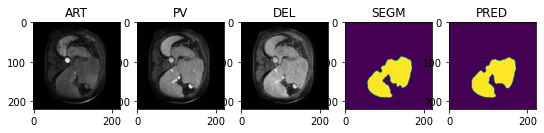

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/10843891_T1_ART_segm.nii.gz
0.9608819484710693
1.6404130592459332
inf
0.9608868360519409
1.6404130592459332
inf
torch.Size([1, 2, 175, 137, 120])
torch.Size([1, 175, 137, 120])


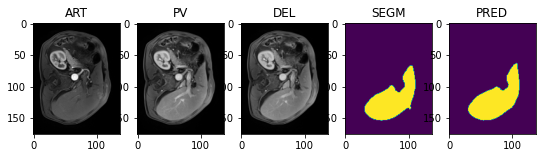

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E101762106_T1_ART_segm.nii.gz
0.9615236520767212
6.386372063707123
inf
0.9637104272842407
1.6575514600332237
0.4376104520917119
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


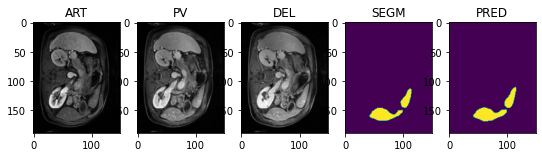

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/12543786_T1_ART_segm.nii.gz
0.9461793899536133
8.19533130767745
inf
0.9567306637763977
1.6368455656463285
inf
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])


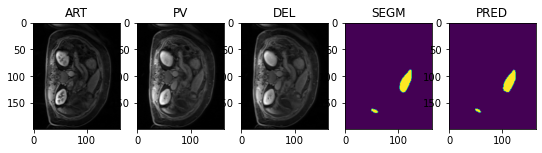

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E107077373_T1_ART_segm.nii.gz
0.9749977588653564
1.3698979101670894
inf
0.975017786026001
0.9829825377838075
inf
torch.Size([1, 2, 220, 172, 120])
torch.Size([1, 220, 172, 120])


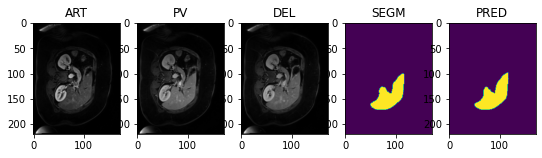

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/3-phases/ART-PV-DEL/E106501028_T1_ART_segm.nii.gz
[0.9691531658172607, 0.9734927415847778, 0.9482581615447998, 0.9255188703536987, 0.96619713306427, 0.9582327604293823, 0.9711110591888428, 0.9834862947463989, 0.9575850963592529, 0.8767755031585693, 0.970361590385437, 0.9716079235076904, 0.9315694570541382, 0.9679044485092163, 0.9619146585464478, 0.9555377960205078, 0.9261969327926636, 0.9637141227722168, 0.948438823223114, 0.9674832820892334, 0.9681332111358643, 0.9720460176467896, 0.9507687091827393, 0.9760717153549194, 0.9728080034255981, 0.9741299152374268, 0.9630217552185059, 0.9681999683380127, 0.9696558713912964, 0.971706748008728, 0.9703969955444336, 0.9632605314254761, 0.9524024724960327, 0.9769778251647949, 0.9637154340744019, 0.9753381013870239, 0.9751772880554199, 0.9721943736076355, 0.96113121509552, 0.9754045009613037, 0.9520190954208374, 0.9465491771697998, 0.9434505701065063, 0.973606586456298

DICE  POST_DICE       HD95  POST_HD95  InferenceTime  \
0  0.969153   0.969155   1.057170   1.057170       0.018913   
1  0.973493   0.977771   4.580656   1.401810       0.004257   
2  0.948258   0.970880   7.253873   1.101971       0.005023   
3  0.925519   0.971004  36.090127   1.509595       0.011035   
4  0.966197   0.966318   1.801147   1.578413       0.004097   

                                AUTOMATED-LIVER-SEGM      EXPERIMENT_ID  
0  /tensor5/data1/mgross/Liver/studies/Contrast-N...  3mpMRI-ART-PV-DEL  
1  /tensor5/data1/mgross/Liver/studies/Contrast-N...  3mpMRI-ART-PV-DEL  
2  /tensor5/data1/mgross/Liver/studies/Contrast-N...  3mpMRI-ART-PV-DEL  
3  /tensor5/data1/mgross/Liver/studies/Contrast-N...  3mpMRI-ART-PV-DEL  
4  /tensor5/data1/mgross/Liver/studies/Contrast-N...  3mpMRI-ART-PV-DEL

In [22]:
roi_size = (224, 224, 128)

df_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=True,
    output_path= OUTPUT_PATH)
    #max_eval = 2)


torch.cuda.empty_cache()
df_test_results['EXPERIMENT_ID'] = '3mpMRI-ART-PV-DEL'
df_test_results.head()

In [23]:
df_test_results.to_csv('../Results/Results-3mpMRI-Net_ART-PV-DEL.csv')

# Public LiverHccSeg Dataset for Benchmark Testing

In [21]:
from monai.data import Dataset, DataLoader, pad_list_data_collate

In [22]:
## Load Public LiverHccSeg Dataset

import glob

LiverHccSeg_pre_path = '/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_and_segms/*/*/*art_pre.nii.gz'
LiverHccSeg_art_path = '/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_and_segms/*/*/*art.nii.gz'
LiverHccSeg_pv_path = '/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_and_segms/*/*/*art_pv.nii.gz'
LiverHccSeg_del_path = '/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_and_segms/*/*/*art_del.nii.gz'
LiverHccSeg_segm_path = '/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_and_segms/*/*/*rater1_liver.nii.gz'

LiverHccSeg_pre_paths = glob.glob(LiverHccSeg_pre_path)
LiverHccSeg_art_paths = glob.glob(LiverHccSeg_art_path)
LiverHccSeg_pv_paths = glob.glob(LiverHccSeg_pv_path)
LiverHccSeg_del_paths = glob.glob(LiverHccSeg_del_path)
LiverHccSeg_segm_paths = glob.glob(LiverHccSeg_segm_path)

LiverHccSeg_accs = []
for i in LiverHccSeg_pre_paths:
    LiverHccSeg_accs.append(i.split('/')[-3])
    
df_LiverHccSeg_imgs = pd.DataFrame({'ACCESSION_ID': LiverHccSeg_accs, 'PRE' : LiverHccSeg_pre_paths,
                                   'ART' : LiverHccSeg_art_paths, 'PV' : LiverHccSeg_pv_paths, 
                                    'DEL' : LiverHccSeg_del_paths, 'SEGM' : LiverHccSeg_segm_paths })

df_LiverHccSeg_imgs

ACCESSION_ID                                                PRE  \
0   TCGA-G3-A25T  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
1   TCGA-G3-AAV2  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
2   TCGA-G3-A3CJ  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
3   TCGA-DD-A4NH  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
4   TCGA-BC-4073  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
5   TCGA-DD-A4NB  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
6   TCGA-G3-A7M7  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
7   TCGA-G3-AAV1  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
8   TCGA-G3-AAV3  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
9   TCGA-G3-AAV7  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
10  TCGA-BC-A3KG  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
11  TCGA-BC-A69I  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
12  TCGA-BC-A5W4  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
13  TCGA-BC-A216  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
14  TCGA-BC-A10Y  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
15  TCGA-DD-A4NF  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
16  TCGA-DD-A4NJ  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   

                                                  ART  \
0   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
1   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
2   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
3   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
4   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
5   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
6   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
7   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
8   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
9   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
10  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
11  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
12  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
13  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
14  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
15  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
16  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   

                                                   PV  \
0   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
1   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
2   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
3   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
4   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
5   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
6   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
7   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
8   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
9   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
10  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
11  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
12  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
13  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
14  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
15  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
16  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   

                                                  DEL  \
0   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
1   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
2   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
3   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
4   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
5   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
6   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
7   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
8   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
9   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
10  /tensor5/data1/mgross/Liver/LiverHccSeg/

In [23]:
LiverHccSeg_test_data_dict = df_LiverHccSeg_imgs.to_dict('records')
print('Number of LiverHccSeg testing files: ', len(LiverHccSeg_test_data_dict))

Number of LiverHccSeg testing files:  17


In [24]:
LiverHccSeg_test_ds = monai.data.Dataset(
    data=LiverHccSeg_test_data_dict, transform=test_transforms)
LiverHccSeg_test_loader = DataLoader(LiverHccSeg_test_ds, batch_size=1, num_workers=4)

torch.Size([3, 1, 180, 180, 112])
torch.Size([3, 1, 180, 180, 112])
torch.Size([3, 1, 180, 180, 112])
TCGA-G3-A25T
ART shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
ART mean: 0.10788898915052414
PV shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
PV mean: 0.10535145550966263
DEL shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
DEL mean: 0.08942414820194244


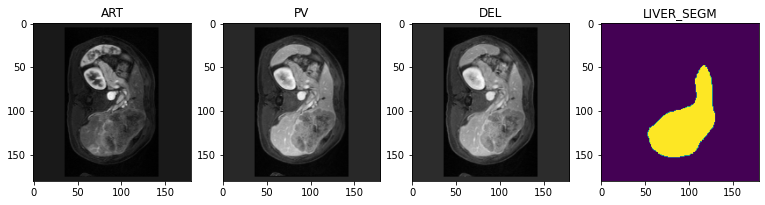

TCGA-G3-AAV2
ART shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
ART mean: 0.12752416729927063
PV shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
PV mean: 0.15688380599021912
DEL shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
DEL mean: 0.13756035268306732


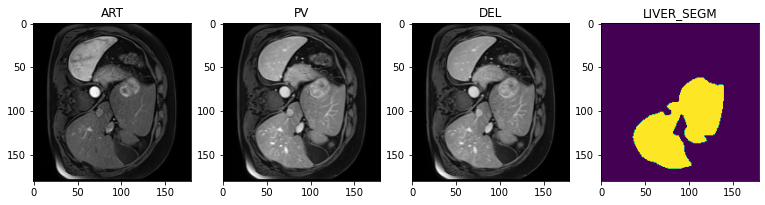

TCGA-G3-A3CJ
ART shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
ART mean: 0.060783401131629944
PV shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
PV mean: 0.0006159089389257133
DEL shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
DEL mean: -0.0002303773071616888


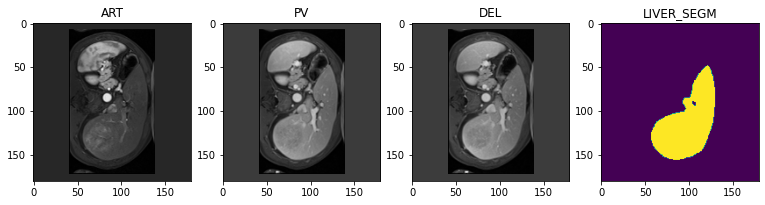

In [25]:
check_ds = monai.data.Dataset(data=LiverHccSeg_test_data_dict[:3], transform=test_transforms)


check_loader = DataLoader(check_ds, batch_size=10, num_workers=0, collate_fn=pad_list_data_collate) #pad_list_data_collate, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['ART'].shape)
print(check_data['PV'].shape)
print(check_data['DEL'].shape)

num_display = 10
if check_data['ART'].shape[0] < num_display:
    num_display = check_data['ART'].shape[0]

for i in range(num_display):
    acc_id, ART, PV, DEL , liver_label = (check_data['ACCESSION_ID'][i],check_data['ART'][i][0], check_data['PV'][i][0], check_data['DEL'][i][0], check_data['SEGM'][i][0])
    print(acc_id)
    
    print('ART shape: {}, label shape: {}'.format(ART.shape, liver_label.shape))
    print('ART mean: {}'.format(np.mean(ART.numpy())))
        
    print('PV shape: {}, label shape: {}'.format(PV.shape, liver_label.shape))
    print('PV mean: {}'.format(np.mean(PV.numpy())))

    
    print('DEL shape: {}, label shape: {}'.format(DEL.shape, liver_label.shape))
    print('DEL mean: {}'.format(np.mean(DEL.numpy())))
    


    slice_num = ART.shape[2]//2
    
    plt.figure('check', (13, 15))

   
    plt.subplot(1, 4, 1)
    plt.title('ART')
    plt.imshow(ART[:,:,slice_num], cmap='gray')

    plt.subplot(1, 4, 2)
    plt.title('PV')
    plt.imshow(PV[:,:,slice_num], cmap='gray')
    
    plt.subplot(1, 4, 3)
    plt.title('DEL')
    plt.imshow(DEL[:,:,slice_num], cmap='gray')
    

    plt.subplot(1, 4, 4)
    plt.title('LIVER_SEGM')
    plt.imshow(liver_label[:,:,slice_num])
    plt.show()


    


0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarni

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the 

0.917300283908844
4.487316101398635
inf
0.917300283908844
4.487316101398635
inf
torch.Size([1, 2, 170, 107, 100])
torch.Size([1, 170, 107, 100])


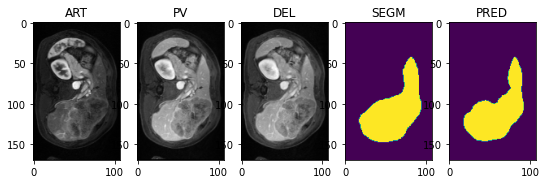

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 28 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 29 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 30 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Us

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 28 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 29 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 30 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarnin

0.955089807510376
1.9807791183364112
inf
0.9551101326942444
1.9807791183364112
inf
torch.Size([1, 2, 180, 180, 110])
torch.Size([1, 180, 180, 110])


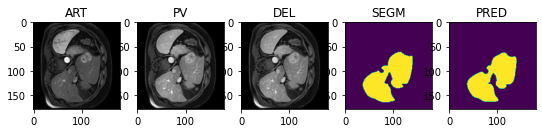

0.9252371788024902
10.189322341852588
inf
0.9259781837463379
8.21247631502596
inf
torch.Size([1, 2, 165, 98, 112])
torch.Size([1, 165, 98, 112])


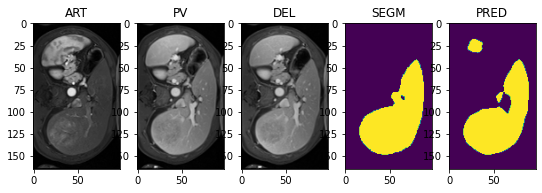

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 179 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 180 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 181 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161:

0.821797788143158
17.03647187892092
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 179 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 180 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 181 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning

0.8242084980010986
15.147360186056453
inf
torch.Size([1, 2, 201, 151, 86])
torch.Size([1, 201, 151, 86])


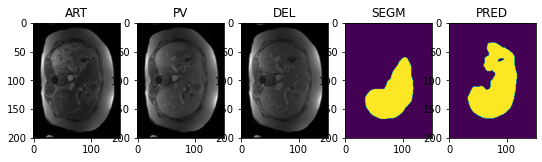

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 54 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 55 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 56 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Us

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 54 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 55 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 56 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarnin

0.9463896751403809
2.2319285864146736
inf
0.9464212656021118
2.0057979331483473
inf
torch.Size([1, 2, 200, 150, 120])
torch.Size([1, 200, 150, 120])


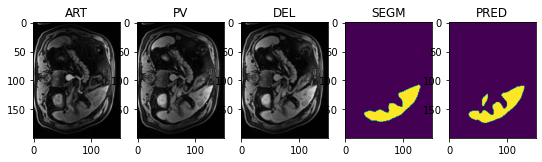

0.9394010305404663
3.0498505060403023
inf
0.9395462274551392
2.2083831564062675
inf
torch.Size([1, 2, 201, 200, 115])
torch.Size([1, 201, 200, 115])


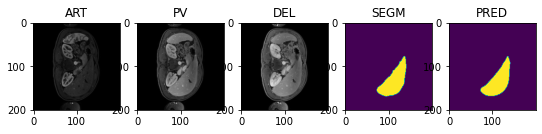

0.9289768934249878
17.47945629822718
inf
0.9341284036636353
3.576898281606129
inf
torch.Size([1, 2, 190, 155, 96])
torch.Size([1, 190, 155, 96])


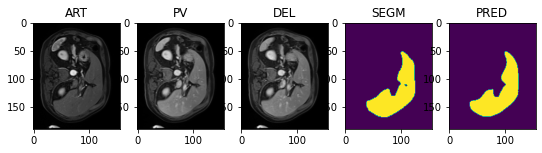

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 79 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 80 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 81 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Us

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 79 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 80 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 81 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarnin

0.9220836162567139
2.6028182866607463
inf
0.9220836162567139
2.6028182866607463
inf
torch.Size([1, 2, 225, 204, 122])
torch.Size([1, 225, 204, 122])


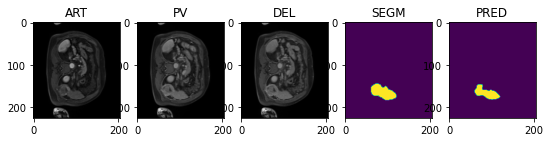

0.941197395324707
2.585732449363128
inf
0.941197395324707
2.585732449363128
inf
torch.Size([1, 2, 175, 175, 110])
torch.Size([1, 175, 175, 110])


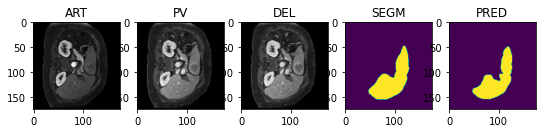

0.8936054706573486
15.930490873599489
inf
0.9157914519309998
6.138476671305388
inf
torch.Size([1, 2, 180, 119, 150])
torch.Size([1, 180, 119, 150])


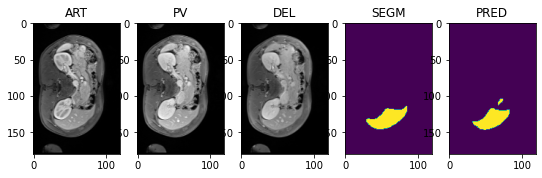

0.9541947841644287
2.2061905156259227
inf
0.9541947841644287
2.2061905156259227
inf
torch.Size([1, 2, 180, 147, 110])
torch.Size([1, 180, 147, 110])


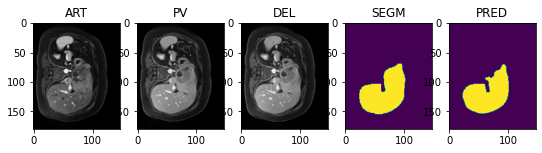

0.9561759233474731
11.886642360337852
inf
0.9571285843849182
2.4407307954583293
inf
torch.Size([1, 2, 200, 163, 153])
torch.Size([1, 200, 163, 153])


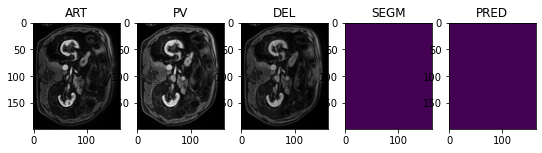

0.9036511182785034
10.384463210201952
inf
0.9051495790481567
6.467104667500325
inf
torch.Size([1, 2, 215, 162, 125])
torch.Size([1, 215, 162, 125])


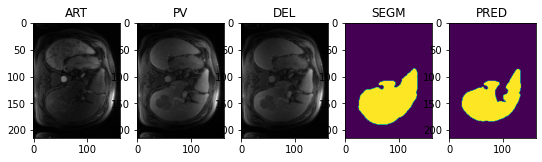

0.9206274151802063
18.510317543591615
inf
0.9269657731056213
3.525223220966268
inf
torch.Size([1, 2, 201, 201, 99])
torch.Size([1, 201, 201, 99])


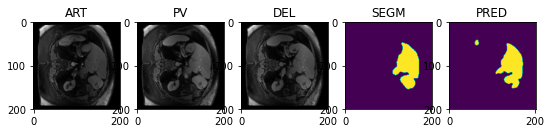

0.795154869556427
27.345022423654925
inf
0.7961913347244263
25.35605749168986
inf
torch.Size([1, 2, 191, 143, 98])
torch.Size([1, 191, 143, 98])


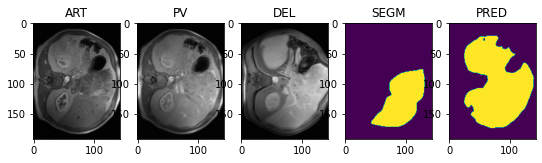

0.9195795059204102
7.859955081803113
inf
0.9209069013595581
2.7695346672175294
inf
torch.Size([1, 2, 201, 151, 90])
torch.Size([1, 201, 151, 90])


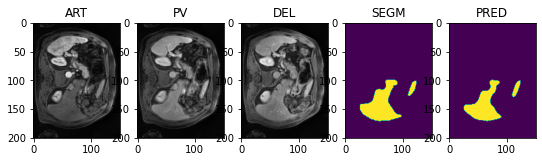

0.8890640735626221
16.426229714453132
inf
0.8984861373901367
3.7307264713143047
inf
torch.Size([1, 2, 201, 151, 105])
torch.Size([1, 201, 151, 105])


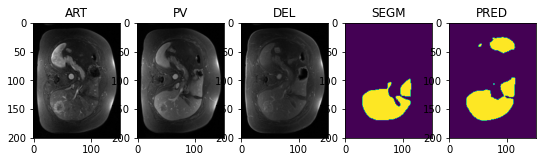

[0.917300283908844, 0.955089807510376, 0.9252371788024902, 0.821797788143158, 0.9463896751403809, 0.9394010305404663, 0.9289768934249878, 0.9220836162567139, 0.941197395324707, 0.8936054706573486, 0.9541947841644287, 0.9561759233474731, 0.9036511182785034, 0.9206274151802063, 0.795154869556427, 0.9195795059204102, 0.8890640735626221]


DICE  POST_DICE       HD95  POST_HD95  InferenceTime
count  17.000000  17.000000  17.000000  17.000000      17.000000
mean    0.913502   0.916517  10.128999   5.614212       0.005848
std     0.044571   0.043736   7.652675   6.059841       0.002523
min     0.795155   0.796191   1.980779   1.980779       0.003556
25%     0.903651   0.915791   2.602818   2.440731       0.004065
50%     0.922084   0.925978  10.189322   3.525223       0.004465
75%     0.941197   0.941197  16.426230   6.138477       0.007001
max     0.956176   0.957129  27.345022  25.356057       0.012341

In [26]:
roi_size = (224, 224, 128)

df_LiverHccSeg_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= LiverHccSeg_test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=False) #, max_eval = 2

torch.cuda.empty_cache()
df_LiverHccSeg_test_results['EXPERIMENT_ID'] = 'LiverHccSeg-ART-PV-DEL'
df_LiverHccSeg_test_results.describe()

In [27]:
df_LiverHccSeg_test_results.to_csv('../LiverHccSegTestingResults/LiverHccSeg-ART-PV-DEL.csv')

## External Testing

In [28]:
import glob 
import pandas as pd

external_testing_img_paths = pd.read_csv('/tensor5/data1/jonofrey/Liver/Paris/registration/nonrigid_nmi/Nonrigid_Registered_NMI_Image_Paths.csv')

included_accs = [1,3, 4, 6, 10, 11, 12, 17, 18, 19, 22, 32, 35, 40, 55, 59]
external_testing_img_paths = external_testing_img_paths[external_testing_img_paths['ACCESSION_ID'].isin(included_accs)]

segm_path = '/tensor5/data1/mgross/Liver/Paris/man_liver_segms/*_PV_LIVER-label.nii.gz'
segm_paths = glob.glob(segm_path)

external_testing_accs = [int(i.split('/')[-1].split('_')[0]) for i in segm_paths]

df_external_testing = pd.DataFrame({'ACCESSION_ID': external_testing_accs, 'SEGM' : segm_paths})
df_external_testing = pd.merge(external_testing_img_paths, df_external_testing, on = 'ACCESSION_ID')

df_external_testing = df_external_testing[['ACCESSION_ID','PV_ART','PV','PV_DEL',  'SEGM']]



df_external_testing.rename(columns={'PV_ART' : 'ART',
                                    'PV_DEL' : 'DEL',
                                    'LIVER': 'SEGM'}, inplace = True)
df_external_testing.columns

Index(['ACCESSION_ID', 'ART', 'PV', 'DEL', 'SEGM'], dtype='object')

In [29]:
external_test_data_dict = df_external_testing.to_dict('records')
print('Number of external testing files: ', len(external_test_data_dict))

Number of external testing files:  16


In [30]:
external_test_ds = monai.data.PersistentDataset(
    data=external_test_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

external_test_loader = DataLoader(external_test_ds, batch_size=1, num_workers=4)

In [31]:
external_test_ds = monai.data.Dataset(
    data=external_test_data_dict, transform=test_transforms)
external_test_loader = DataLoader(external_test_ds, batch_size=1, num_workers=4)

torch.Size([1, 1, 210, 210, 100])
torch.Size([1, 1, 210, 210, 100])
torch.Size([1, 1, 210, 210, 100])
tensor(1)
ART shape: torch.Size([210, 210, 100]), label shape: torch.Size([210, 210, 100])
ART mean: 0.1549057960510254
PV shape: torch.Size([210, 210, 100]), label shape: torch.Size([210, 210, 100])
PV mean: 0.18028146028518677
DEL shape: torch.Size([210, 210, 100]), label shape: torch.Size([210, 210, 100])
DEL mean: 0.12489209324121475


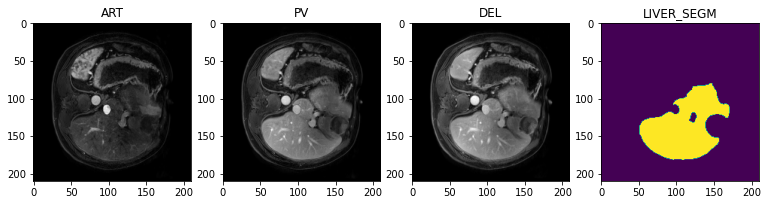

In [32]:
check_ds = monai.data.Dataset(data=external_test_data_dict[:1], transform=test_transforms)


check_loader = DataLoader(check_ds, batch_size=10, num_workers=0, collate_fn=list_data_collate) #collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['ART'].shape)
print(check_data['PV'].shape)
print(check_data['DEL'].shape)


num_display = 10
if check_data['ART'].shape[0] < num_display:
    num_display = check_data['ART'].shape[0]

for i in range(num_display):
    acc_id, ART, PV, DEL , liver_label = (check_data['ACCESSION_ID'][i], check_data['ART'][i][0],check_data['PV'][i][0],check_data['DEL'][i][0], check_data['SEGM'][i][0])
    print(acc_id)
 
    
    print('ART shape: {}, label shape: {}'.format(ART.shape, liver_label.shape))
    print('ART mean: {}'.format(np.mean(ART.numpy())))
    
    
    print('PV shape: {}, label shape: {}'.format(PV.shape, liver_label.shape))
    print('PV mean: {}'.format(np.mean(PV.numpy())))
    
    print('DEL shape: {}, label shape: {}'.format(DEL.shape, liver_label.shape))
    print('DEL mean: {}'.format(np.mean(DEL.numpy())))



    slice_num = ART.shape[2]//2
    
    plt.figure('check', (13, 15))

   
    plt.subplot(1, 4, 1)
    plt.title('ART')
    plt.imshow(ART[:,:,slice_num], cmap='gray')

    plt.subplot(1, 4, 2)
    plt.title('PV')
    plt.imshow(PV[:,:,slice_num], cmap='gray')
    
    plt.subplot(1, 4 ,3)
    plt.title('DEL')
    plt.imshow(DEL[:,:,slice_num], cmap='gray')

    

    plt.subplot(1, 4, 4)
    plt.title('LIVER_SEGM')
    plt.imshow(liver_label[:,:,slice_num])
    plt.show()


    


0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarni

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the 

0.9219982624053955
3.336905526381171
inf


/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 195 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 196 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 197 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning

0.9219995737075806
3.336905526381171
inf
torch.Size([1, 2, 210, 210, 100])
torch.Size([1, 210, 210, 100])


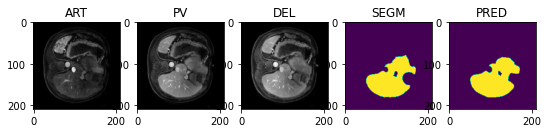

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 61 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 62 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 63 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Us

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 61 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 62 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 63 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarnin

0.9628400802612305
2.0695947980113973
inf
0.9628425240516663
2.0695947980113973
inf
torch.Size([1, 2, 230, 230, 125])
torch.Size([1, 230, 230, 125])


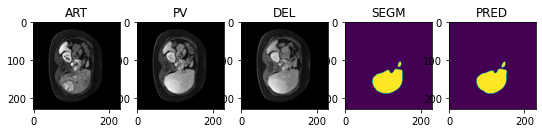

0.9117686152458191
6.434071746455583
inf
0.9137920141220093
3.4622679802204583
inf
torch.Size([1, 2, 228, 228, 105])
torch.Size([1, 228, 228, 105])


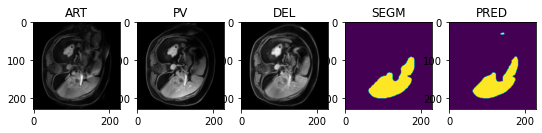

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 81 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 81 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 82 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWa

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 81 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 81 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 82 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: t

0.9606741070747375
1.533283121347276
inf
0.9606839418411255
1.533283121347276
inf
torch.Size([1, 2, 211, 211, 104])
torch.Size([1, 211, 211, 104])


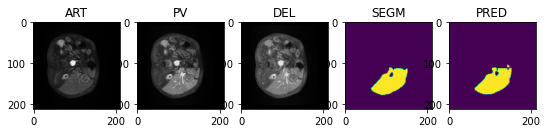

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 171 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 172 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 172 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWar

0.8496947288513184
19.53908838191455
inf
0.8521509170532227
18.350582424186154
inf
torch.Size([1, 2, 191, 167, 118])
torch.Size([1, 191, 167, 118])


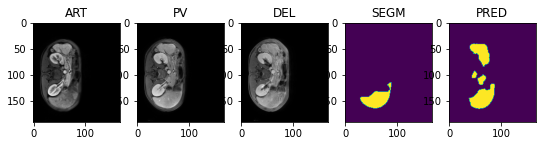

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 171 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 171 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")


0.9141075611114502
14.760326183382318
inf
0.9193165898323059
8.805484728571262
inf
torch.Size([1, 2, 211, 211, 109])
torch.Size([1, 211, 211, 109])


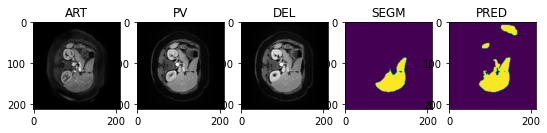

0.9106305837631226
2.696589793828725
inf
0.9106305837631226
2.696589793828725
inf
torch.Size([1, 2, 201, 178, 108])
torch.Size([1, 201, 178, 108])


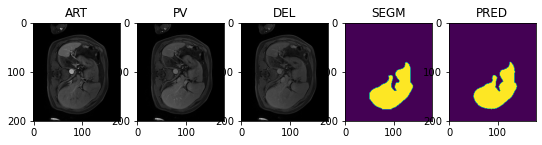

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 90 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 91 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 91 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarnin

0.8263291120529175
13.852478124783728
inf
0.8263748288154602
13.847352442258615
inf
torch.Size([1, 2, 204, 204, 100])
torch.Size([1, 204, 204, 100])


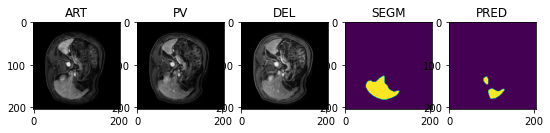

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 156 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 157 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 157 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: Use

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 156 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 157 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 157 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning

0.8935160636901855
8.249459291682694
inf
0.8935160636901855
8.249459291682694
inf
torch.Size([1, 2, 189, 189, 105])
torch.Size([1, 189, 189, 105])


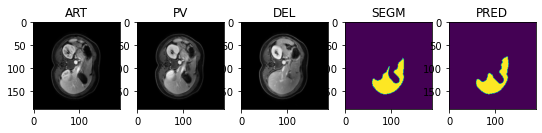

0.8247756958007812
25.89321678213621
inf
0.8450852036476135
13.736456032631892
inf
torch.Size([1, 2, 201, 201, 96])
torch.Size([1, 201, 201, 96])


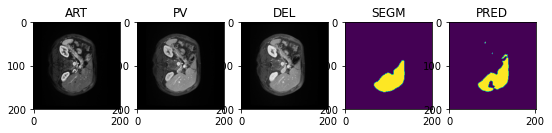

0.7576360702514648
15.578245203035152
inf
0.7576483488082886
15.578245203035152
inf
torch.Size([1, 2, 210, 210, 100])
torch.Size([1, 210, 210, 100])


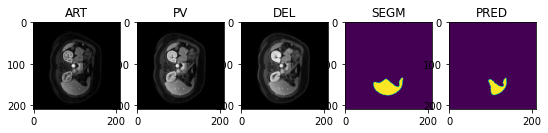

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 96 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 96 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")


0.9696894288063049
1.2371212567231924
0.3827816294383727
0.9696894288063049
1.2371212567231924
0.3827816294383727
torch.Size([1, 2, 210, 210, 110])
torch.Size([1, 210, 210, 110])


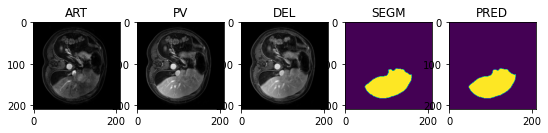

0.9687399864196777
2.1803693543470573
inf
0.9687399864196777
2.1803693543470573
inf
torch.Size([1, 2, 210, 210, 125])
torch.Size([1, 210, 210, 125])


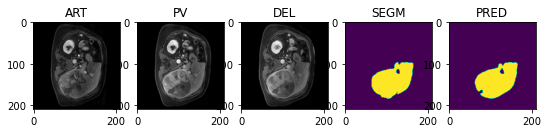

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 134 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: UserWarning: the prediction of class 134 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:161: UserWarning: the ground truth of class 135 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:163: Use

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 134 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning: the prediction of class 134 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:156: UserWarning: the ground truth of class 135 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/monai/metrics/surface_distance.py:158: UserWarning

0.9440137147903442
4.8005040379558706
inf
0.9440137147903442
4.8005040379558706
inf
torch.Size([1, 2, 172, 172, 100])
torch.Size([1, 172, 172, 100])


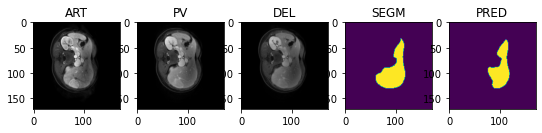

0.892957329750061
20.06712105976341
inf
0.9001071453094482
10.581783276215258
inf
torch.Size([1, 2, 221, 221, 114])
torch.Size([1, 221, 221, 114])


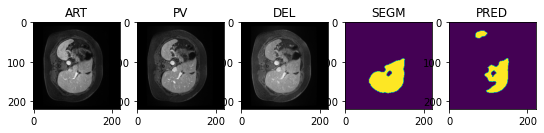

0.9460116624832153
2.0861417066933674
inf


In [ ]:
roi_size = (224, 224, 128)

df_external_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= external_test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=False) #, max_eval = 2

torch.cuda.empty_cache()
df_external_test_results['EXPERIMENT_ID'] = 'ART-PV-DEL'
df_external_test_results.describe()

In [ ]:
df_external_test_results.to_csv('../ExternalTestingResults/Results-3mpMRI-Net-ART-PV-DEL.csv')